# Hyperparameter Search for SBI Trainer with sbi_delta

This notebook performs a hyperparameter search for the SBI Trainer using the sbi_delta package. We systematically vary key SNPE training parameters and evaluate their effect on model performance.

**Outline:**
- Import required libraries
- Define experiment configuration
- Define hyperparameter grid
- Run hyperparameter search loop
- Collect and analyze results
- Visualize hyperparameter effects
- Save results

In [1]:
# Section 1: Import Required Libraries
import os, sys
base_path = os.path.abspath("../..")
sys.path.append(base_path)  # Adjust path as needed
import numpy as np
import torch
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sbi.inference import SNPE
from sbi_delta.config import BaseConfig, ExcitationConfig, FilterConfig, PriorConfig
from sbi_delta.spectra_manager import SpectraManager
from sbi_delta.excitation_manager import ExcitationManager
from sbi_delta.filter_bank import FilterBank
from sbi_delta.prior_manager import PriorManager
from sbi_delta.simulator.emission_simulator import EmissionSimulator
from sbi_delta.trainer import Trainer

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Section 2: Define Experiment Configuration
# Define fluorophores, filters, and prior
fluorophore_names = ["JF479", "JF525", "JF552", "JF608", "JFX650", "JFX673"]

base_cfg = BaseConfig(
    min_wavelength=400,
    max_wavelength=750,
    wavelength_step=1,
    spectra_folder=os.path.join(base_path, "data/spectra_npz"),
    dye_names=fluorophore_names,
    bg_dye='AF_v1',
    photon_budget=1000,
)
exc_cfg = ExcitationConfig(excitation_mode="min_crosstalk")
filter_cfgs = [
    FilterConfig(start, stop, sharpness=1)
    for start, stop in zip([490, 530, 570, 620, 680], [530, 570, 620, 680, 740])
]
prior_cfg = PriorConfig(
    dirichlet_concentration=5.0,
    include_background_ratio=True,
    background_ratio_bounds=(0.05, 0.15),
)

spectra_mgr = SpectraManager(base_cfg)
spectra_mgr.load()
excitation_mgr = ExcitationManager(base_cfg, exc_cfg, spectra_mgr)
filter_bank = FilterBank(base_cfg, filter_cfgs)
prior_mgr = PriorManager(prior_cfg, base_cfg)
simulator = EmissionSimulator(
    spectra_manager=spectra_mgr,
    filter_bank=filter_bank,
    config=base_cfg,
    excitation_manager=excitation_mgr,
    prior_manager=prior_mgr,
)
print("Simulator and managers initialized.")

INFO:sbi_delta.spectra_manager:Initialized SpectraManager(folder=/groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz, dyes=['JF479', 'JF525', 'JF552', 'JF608', 'JFX650', 'JFX673'], bg_dye=AF_v1)
INFO:sbi_delta.spectra_manager:Starting load() of spectra
INFO:sbi_delta.spectra_manager:Found 22 .npz files in '/groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz'
INFO:sbi_delta.spectra_manager:Loading emission spectrum for dye 'JF479' from /groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz/JF479.npz
INFO:sbi_delta.spectra_manager:Completed processing for 'JF479'
INFO:sbi_delta.spectra_manager:Loading emission spectrum for dye 'JF525' from /groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz/JF525.npz
INFO:sbi_delta.spectra_manager:Completed processing for 'JF525'
INFO:sbi_delta.spectra_manager:Loading emission spectrum for dye 'JF552' from /groups/spruston/home/moharb/sbi-DELTA/data/spectra_npz/JF552.npz
INFO:sbi_delta.spectra_manager:Starting load() of spectra
INFO:sbi_delt

Simulator and managers initialized.


In [3]:
# Section 3: Define Hyperparameter Grid
# Specify the hyperparameters to search over
hyperparams_grid = {
    'training_batch_size': [64, 128, 256],
    'learning_rate': [1e-3, 5e-4, 1e-4],
    'validation_fraction': [0.05, 0.1, 0.2],
    'stop_after_epochs': [5, 10, 20]
}

# Create all combinations of hyperparameters
grid_keys = list(hyperparams_grid.keys())
grid_combos = list(itertools.product(*[hyperparams_grid[k] for k in grid_keys]))
print(f"Total hyperparameter combinations: {len(grid_combos)}")

Total hyperparameter combinations: 81


In [4]:
# Section 4: Run Hyperparameter Search Loop
from tqdm import tqdm
results = []

n_train = 2000  # Reduce for speed; increase for real experiments
n_val = 500

for idx, combo in enumerate(tqdm(grid_combos, desc='Hyperparameter Search')):
    params = dict(zip(grid_keys, combo))
    print(f"\nRunning combo {idx+1}/{len(grid_combos)}: {params}")
    trainer = Trainer(
        simulator,
        n_train=n_train,
        n_val=n_val,
        save_dir=None  # Don't save intermediate results
    )
    # Patch the train method to use current hyperparameters
    def train_with_params(self):
        train_theta, train_x = self.generate_training_data()
        inference = SNPE(prior=self.prior)
        inference.append_simulations(train_theta, train_x)
        density_estimator = inference.train(
            training_batch_size=params['training_batch_size'],
            learning_rate=params['learning_rate'],
            validation_fraction=params['validation_fraction'],
            stop_after_epochs=params['stop_after_epochs'],
            show_train_summary=False
        )
        self.posterior = inference.build_posterior(density_estimator)
        return self.posterior
    import types
    trainer.train = types.MethodType(train_with_params, trainer)
    try:
        posterior = trainer.train()
        r2_scores, rmse_scores, rmse = trainer.validate()
        mean_r2 = np.mean(r2_scores)
        mean_rmse = np.mean(rmse_scores)
        mean_width = np.mean(trainer.results['posterior_width'])
        results.append({
            **params,
            'mean_r2': mean_r2,
            'mean_rmse': mean_rmse,
            'mean_width': mean_width
        })
    except Exception as e:
        print(f"Failed for params {params}: {e}")
        results.append({**params, 'mean_r2': np.nan, 'mean_rmse': np.nan, 'mean_width': np.nan})

Hyperparameter Search:   0%|          | 0/81 [00:00<?, ?it/s]


Running combo 1/81: {'training_batch_size': 64, 'learning_rate': 0.001, 'validation_fraction': 0.05, 'stop_after_epochs': 5}
 Neural network successfully converged after 22 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:15<00:00, 32.15it/s]

Hyperparameter Search:   1%|          | 1/81 [00:26<34:43, 26.04s/it]

Validation mean R^2: 0.909, RMSE: 0.0175

Running combo 2/81: {'training_batch_size': 64, 'learning_rate': 0.001, 'validation_fraction': 0.05, 'stop_after_epochs': 10}
 Neural network successfully converged after 31 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:16<00:00, 31.16it/s]

Hyperparameter Search:   2%|▏         | 2/81 [00:51<33:48, 25.67s/it]

Validation mean R^2: 0.902, RMSE: 0.0178

Running combo 3/81: {'training_batch_size': 64, 'learning_rate': 0.001, 'validation_fraction': 0.05, 'stop_after_epochs': 20}
 Neural network successfully converged after 64 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:15<00:00, 31.87it/s]

Hyperparameter Search:   4%|▎         | 3/81 [01:23<37:10, 28.59s/it]

Validation mean R^2: 0.908, RMSE: 0.0172

Running combo 4/81: {'training_batch_size': 64, 'learning_rate': 0.001, 'validation_fraction': 0.1, 'stop_after_epochs': 5}
 Neural network successfully converged after 26 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:   5%|▍         | 4/81 [01:44<32:46, 25.54s/it]

Validation mean R^2: 0.911, RMSE: 0.0174

Running combo 5/81: {'training_batch_size': 64, 'learning_rate': 0.001, 'validation_fraction': 0.1, 'stop_after_epochs': 10}
 Neural network successfully converged after 48 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:14<00:00, 35.17it/s]

Hyperparameter Search:   6%|▌         | 5/81 [02:08<31:54, 25.19s/it]

Validation mean R^2: 0.903, RMSE: 0.0178

Running combo 6/81: {'training_batch_size': 64, 'learning_rate': 0.001, 'validation_fraction': 0.1, 'stop_after_epochs': 20}
 Neural network successfully converged after 73 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:   7%|▋         | 6/81 [02:36<32:21, 25.89s/it]

Validation mean R^2: 0.910, RMSE: 0.0177

Running combo 7/81: {'training_batch_size': 64, 'learning_rate': 0.001, 'validation_fraction': 0.2, 'stop_after_epochs': 5}
 Neural network successfully converged after 35 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:   9%|▊         | 7/81 [02:56<29:48, 24.16s/it]

Validation mean R^2: 0.908, RMSE: 0.0176

Running combo 8/81: {'training_batch_size': 64, 'learning_rate': 0.001, 'validation_fraction': 0.2, 'stop_after_epochs': 10}
 Neural network successfully converged after 50 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  10%|▉         | 8/81 [03:19<28:41, 23.58s/it]

Validation mean R^2: 0.911, RMSE: 0.0176

Running combo 9/81: {'training_batch_size': 64, 'learning_rate': 0.001, 'validation_fraction': 0.2, 'stop_after_epochs': 20}
 Neural network successfully converged after 86 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  11%|█         | 9/81 [03:47<30:08, 25.12s/it]

Validation mean R^2: 0.901, RMSE: 0.0176

Running combo 10/81: {'training_batch_size': 64, 'learning_rate': 0.0005, 'validation_fraction': 0.05, 'stop_after_epochs': 5}
 Neural network successfully converged after 37 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 37.58it/s]

Hyperparameter Search:  12%|█▏        | 10/81 [04:09<28:26, 24.03s/it]

Validation mean R^2: 0.906, RMSE: 0.0177

Running combo 11/81: {'training_batch_size': 64, 'learning_rate': 0.0005, 'validation_fraction': 0.05, 'stop_after_epochs': 10}
 Neural network successfully converged after 42 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  14%|█▎        | 11/81 [04:31<27:28, 23.55s/it]

Validation mean R^2: 0.911, RMSE: 0.0174

Running combo 12/81: {'training_batch_size': 64, 'learning_rate': 0.0005, 'validation_fraction': 0.05, 'stop_after_epochs': 20}
 Neural network successfully converged after 51 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 37.24it/s]

Hyperparameter Search:  15%|█▍        | 12/81 [04:55<27:09, 23.62s/it]

Validation mean R^2: 0.901, RMSE: 0.0182

Running combo 13/81: {'training_batch_size': 64, 'learning_rate': 0.0005, 'validation_fraction': 0.1, 'stop_after_epochs': 5}
 Neural network successfully converged after 41 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  16%|█▌        | 13/81 [05:17<26:10, 23.09s/it]

Validation mean R^2: 0.905, RMSE: 0.0174

Running combo 14/81: {'training_batch_size': 64, 'learning_rate': 0.0005, 'validation_fraction': 0.1, 'stop_after_epochs': 10}
 Neural network successfully converged after 67 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  17%|█▋        | 14/81 [05:43<26:54, 24.10s/it]

Validation mean R^2: 0.914, RMSE: 0.0171

Running combo 15/81: {'training_batch_size': 64, 'learning_rate': 0.0005, 'validation_fraction': 0.1, 'stop_after_epochs': 20}
 Neural network successfully converged after 72 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.99it/s]

Hyperparameter Search:  19%|█▊        | 15/81 [06:11<27:36, 25.10s/it]

Validation mean R^2: 0.911, RMSE: 0.0173

Running combo 16/81: {'training_batch_size': 64, 'learning_rate': 0.0005, 'validation_fraction': 0.2, 'stop_after_epochs': 5}
 Neural network successfully converged after 51 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  20%|█▉        | 16/81 [06:34<26:38, 24.60s/it]

Validation mean R^2: 0.872, RMSE: 0.0210

Running combo 17/81: {'training_batch_size': 64, 'learning_rate': 0.0005, 'validation_fraction': 0.2, 'stop_after_epochs': 10}
 Neural network successfully converged after 73 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 37.52it/s]

Hyperparameter Search:  21%|██        | 17/81 [07:00<26:48, 25.13s/it]

Validation mean R^2: 0.903, RMSE: 0.0177

Running combo 18/81: {'training_batch_size': 64, 'learning_rate': 0.0005, 'validation_fraction': 0.2, 'stop_after_epochs': 20}
 Neural network successfully converged after 72 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  22%|██▏       | 18/81 [07:26<26:36, 25.34s/it]

Validation mean R^2: 0.904, RMSE: 0.0178

Running combo 19/81: {'training_batch_size': 64, 'learning_rate': 0.0001, 'validation_fraction': 0.05, 'stop_after_epochs': 5}
 Neural network successfully converged after 76 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  23%|██▎       | 19/81 [07:55<27:05, 26.22s/it]

Validation mean R^2: 0.893, RMSE: 0.0197

Running combo 20/81: {'training_batch_size': 64, 'learning_rate': 0.0001, 'validation_fraction': 0.05, 'stop_after_epochs': 10}
 Neural network successfully converged after 106 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.43it/s]

Hyperparameter Search:  25%|██▍       | 20/81 [08:28<28:47, 28.32s/it]

Validation mean R^2: 0.899, RMSE: 0.0176

Running combo 21/81: {'training_batch_size': 64, 'learning_rate': 0.0001, 'validation_fraction': 0.05, 'stop_after_epochs': 20}
 Neural network successfully converged after 179 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.79it/s]

Hyperparameter Search:  26%|██▌       | 21/81 [09:13<33:25, 33.42s/it]

Validation mean R^2: 0.902, RMSE: 0.0176

Running combo 22/81: {'training_batch_size': 64, 'learning_rate': 0.0001, 'validation_fraction': 0.1, 'stop_after_epochs': 5}
 Neural network successfully converged after 98 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:12<00:00, 39.03it/s]

Hyperparameter Search:  27%|██▋       | 22/81 [09:44<32:04, 32.61s/it]

Validation mean R^2: 0.795, RMSE: 0.0285

Running combo 23/81: {'training_batch_size': 64, 'learning_rate': 0.0001, 'validation_fraction': 0.1, 'stop_after_epochs': 10}
 Neural network successfully converged after 129 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  28%|██▊       | 23/81 [10:20<32:37, 33.75s/it]

Validation mean R^2: 0.901, RMSE: 0.0180

Running combo 24/81: {'training_batch_size': 64, 'learning_rate': 0.0001, 'validation_fraction': 0.1, 'stop_after_epochs': 20}
 Neural network successfully converged after 179 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.92it/s]

Hyperparameter Search:  30%|██▉       | 24/81 [11:05<35:15, 37.12s/it]

Validation mean R^2: 0.904, RMSE: 0.0176

Running combo 25/81: {'training_batch_size': 64, 'learning_rate': 0.0001, 'validation_fraction': 0.2, 'stop_after_epochs': 5}
 Neural network successfully converged after 139 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  31%|███       | 25/81 [11:42<34:26, 36.90s/it]

Validation mean R^2: 0.906, RMSE: 0.0180

Running combo 26/81: {'training_batch_size': 64, 'learning_rate': 0.0001, 'validation_fraction': 0.2, 'stop_after_epochs': 10}
 Neural network successfully converged after 178 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 37.37it/s]

Hyperparameter Search:  32%|███▏      | 26/81 [12:24<35:21, 38.57s/it]

Validation mean R^2: 0.894, RMSE: 0.0190

Running combo 27/81: {'training_batch_size': 64, 'learning_rate': 0.0001, 'validation_fraction': 0.2, 'stop_after_epochs': 20}
 Neural network successfully converged after 239 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.65it/s]

Hyperparameter Search:  33%|███▎      | 27/81 [13:16<38:18, 42.57s/it]

Validation mean R^2: 0.909, RMSE: 0.0178

Running combo 28/81: {'training_batch_size': 128, 'learning_rate': 0.001, 'validation_fraction': 0.05, 'stop_after_epochs': 5}
 Neural network successfully converged after 35 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  35%|███▍      | 28/81 [13:35<31:20, 35.49s/it]

Validation mean R^2: 0.914, RMSE: 0.0172

Running combo 29/81: {'training_batch_size': 128, 'learning_rate': 0.001, 'validation_fraction': 0.05, 'stop_after_epochs': 10}
 Neural network successfully converged after 50 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  36%|███▌      | 29/81 [13:55<26:50, 30.96s/it]

Validation mean R^2: 0.911, RMSE: 0.0176

Running combo 30/81: {'training_batch_size': 128, 'learning_rate': 0.001, 'validation_fraction': 0.05, 'stop_after_epochs': 20}
 Neural network successfully converged after 91 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 37.38it/s]

Hyperparameter Search:  37%|███▋      | 30/81 [14:20<24:35, 28.94s/it]

Validation mean R^2: 0.908, RMSE: 0.0171

Running combo 31/81: {'training_batch_size': 128, 'learning_rate': 0.001, 'validation_fraction': 0.1, 'stop_after_epochs': 5}
 Neural network successfully converged after 44 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.86it/s]

Hyperparameter Search:  38%|███▊      | 31/81 [14:40<21:52, 26.24s/it]

Validation mean R^2: 0.908, RMSE: 0.0174

Running combo 32/81: {'training_batch_size': 128, 'learning_rate': 0.001, 'validation_fraction': 0.1, 'stop_after_epochs': 10}
 Neural network successfully converged after 50 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 37.65it/s]

Hyperparameter Search:  40%|███▉      | 32/81 [15:00<19:57, 24.45s/it]

Validation mean R^2: 0.907, RMSE: 0.0176

Running combo 33/81: {'training_batch_size': 128, 'learning_rate': 0.001, 'validation_fraction': 0.1, 'stop_after_epochs': 20}
 Neural network successfully converged after 62 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 37.10it/s]

Hyperparameter Search:  41%|████      | 33/81 [15:21<18:52, 23.59s/it]

Validation mean R^2: 0.907, RMSE: 0.0173

Running combo 34/81: {'training_batch_size': 128, 'learning_rate': 0.001, 'validation_fraction': 0.2, 'stop_after_epochs': 5}
 Neural network successfully converged after 41 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  42%|████▏     | 34/81 [15:40<17:25, 22.25s/it]

Validation mean R^2: 0.904, RMSE: 0.0175

Running combo 35/81: {'training_batch_size': 128, 'learning_rate': 0.001, 'validation_fraction': 0.2, 'stop_after_epochs': 10}
 Neural network successfully converged after 103 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 37.63it/s]

Hyperparameter Search:  43%|████▎     | 35/81 [16:05<17:35, 22.95s/it]

Validation mean R^2: 0.896, RMSE: 0.0184

Running combo 36/81: {'training_batch_size': 128, 'learning_rate': 0.001, 'validation_fraction': 0.2, 'stop_after_epochs': 20}
 Neural network successfully converged after 72 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.35it/s]

Hyperparameter Search:  44%|████▍     | 36/81 [16:27<17:03, 22.75s/it]

Validation mean R^2: 0.912, RMSE: 0.0174

Running combo 37/81: {'training_batch_size': 128, 'learning_rate': 0.0005, 'validation_fraction': 0.05, 'stop_after_epochs': 5}
 Neural network successfully converged after 54 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  46%|████▌     | 37/81 [16:48<16:15, 22.18s/it]

Validation mean R^2: 0.906, RMSE: 0.0179

Running combo 38/81: {'training_batch_size': 128, 'learning_rate': 0.0005, 'validation_fraction': 0.05, 'stop_after_epochs': 10}
 Neural network successfully converged after 80 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 37.43it/s]

Hyperparameter Search:  47%|████▋     | 38/81 [17:12<16:08, 22.53s/it]

Validation mean R^2: 0.902, RMSE: 0.0183

Running combo 39/81: {'training_batch_size': 128, 'learning_rate': 0.0005, 'validation_fraction': 0.05, 'stop_after_epochs': 20}
 Neural network successfully converged after 87 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  48%|████▊     | 39/81 [17:36<16:04, 22.97s/it]

Validation mean R^2: 0.907, RMSE: 0.0174

Running combo 40/81: {'training_batch_size': 128, 'learning_rate': 0.0005, 'validation_fraction': 0.1, 'stop_after_epochs': 5}
 Neural network successfully converged after 41 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.77it/s]

Hyperparameter Search:  49%|████▉     | 40/81 [17:55<15:01, 22.00s/it]

Validation mean R^2: 0.907, RMSE: 0.0181

Running combo 41/81: {'training_batch_size': 128, 'learning_rate': 0.0005, 'validation_fraction': 0.1, 'stop_after_epochs': 10}
 Neural network successfully converged after 72 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  51%|█████     | 41/81 [18:16<14:29, 21.73s/it]

Validation mean R^2: 0.903, RMSE: 0.0180

Running combo 42/81: {'training_batch_size': 128, 'learning_rate': 0.0005, 'validation_fraction': 0.1, 'stop_after_epochs': 20}
 Neural network successfully converged after 74 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.39it/s]

Hyperparameter Search:  52%|█████▏    | 42/81 [18:39<14:23, 22.13s/it]

Validation mean R^2: 0.896, RMSE: 0.0176

Running combo 43/81: {'training_batch_size': 128, 'learning_rate': 0.0005, 'validation_fraction': 0.2, 'stop_after_epochs': 5}
 Neural network successfully converged after 55 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 37.59it/s]

Hyperparameter Search:  53%|█████▎    | 43/81 [19:00<13:40, 21.59s/it]

Validation mean R^2: 0.910, RMSE: 0.0177

Running combo 44/81: {'training_batch_size': 128, 'learning_rate': 0.0005, 'validation_fraction': 0.2, 'stop_after_epochs': 10}
 Neural network successfully converged after 82 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  54%|█████▍    | 44/81 [19:23<13:35, 22.03s/it]

Validation mean R^2: 0.910, RMSE: 0.0175

Running combo 45/81: {'training_batch_size': 128, 'learning_rate': 0.0005, 'validation_fraction': 0.2, 'stop_after_epochs': 20}
 Neural network successfully converged after 96 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 37.56it/s]

Hyperparameter Search:  56%|█████▌    | 45/81 [19:47<13:34, 22.62s/it]

Validation mean R^2: 0.905, RMSE: 0.0177

Running combo 46/81: {'training_batch_size': 128, 'learning_rate': 0.0001, 'validation_fraction': 0.05, 'stop_after_epochs': 5}
 Neural network successfully converged after 151 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  57%|█████▋    | 46/81 [20:17<14:30, 24.87s/it]

Validation mean R^2: 0.888, RMSE: 0.0192

Running combo 47/81: {'training_batch_size': 128, 'learning_rate': 0.0001, 'validation_fraction': 0.05, 'stop_after_epochs': 10}
 Neural network successfully converged after 249 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  58%|█████▊    | 47/81 [20:57<16:38, 29.38s/it]

Validation mean R^2: 0.910, RMSE: 0.0175

Running combo 48/81: {'training_batch_size': 128, 'learning_rate': 0.0001, 'validation_fraction': 0.05, 'stop_after_epochs': 20}
 Neural network successfully converged after 380 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.33it/s]

Hyperparameter Search:  59%|█████▉    | 48/81 [21:50<20:02, 36.43s/it]

Validation mean R^2: 0.913, RMSE: 0.0178

Running combo 49/81: {'training_batch_size': 128, 'learning_rate': 0.0001, 'validation_fraction': 0.1, 'stop_after_epochs': 5}
 Neural network successfully converged after 121 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  60%|██████    | 49/81 [22:17<17:58, 33.71s/it]

Validation mean R^2: 0.905, RMSE: 0.0179

Running combo 50/81: {'training_batch_size': 128, 'learning_rate': 0.0001, 'validation_fraction': 0.1, 'stop_after_epochs': 10}
 Neural network successfully converged after 153 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 35.79it/s]

Hyperparameter Search:  62%|██████▏   | 50/81 [22:48<16:59, 32.90s/it]

Validation mean R^2: 0.873, RMSE: 0.0212

Running combo 51/81: {'training_batch_size': 128, 'learning_rate': 0.0001, 'validation_fraction': 0.1, 'stop_after_epochs': 20}
 Neural network successfully converged after 244 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.83it/s]

Hyperparameter Search:  63%|██████▎   | 51/81 [23:28<17:27, 34.91s/it]

Validation mean R^2: 0.910, RMSE: 0.0178

Running combo 52/81: {'training_batch_size': 128, 'learning_rate': 0.0001, 'validation_fraction': 0.2, 'stop_after_epochs': 5}
 Neural network successfully converged after 188 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.87it/s]

Hyperparameter Search:  64%|██████▍   | 52/81 [24:00<16:32, 34.24s/it]

Validation mean R^2: 0.906, RMSE: 0.0186

Running combo 53/81: {'training_batch_size': 128, 'learning_rate': 0.0001, 'validation_fraction': 0.2, 'stop_after_epochs': 10}
 Neural network successfully converged after 195 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.36it/s]

Hyperparameter Search:  65%|██████▌   | 53/81 [24:34<15:53, 34.05s/it]

Validation mean R^2: 0.896, RMSE: 0.0182

Running combo 54/81: {'training_batch_size': 128, 'learning_rate': 0.0001, 'validation_fraction': 0.2, 'stop_after_epochs': 20}
 Neural network successfully converged after 256 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  67%|██████▋   | 54/81 [25:12<15:54, 35.37s/it]

Validation mean R^2: 0.904, RMSE: 0.0180

Running combo 55/81: {'training_batch_size': 256, 'learning_rate': 0.001, 'validation_fraction': 0.05, 'stop_after_epochs': 5}
 Neural network successfully converged after 60 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  68%|██████▊   | 55/81 [25:32<13:14, 30.56s/it]

Validation mean R^2: 0.910, RMSE: 0.0175

Running combo 56/81: {'training_batch_size': 256, 'learning_rate': 0.001, 'validation_fraction': 0.05, 'stop_after_epochs': 10}
 Neural network successfully converged after 77 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  69%|██████▉   | 56/81 [25:52<11:25, 27.41s/it]

Validation mean R^2: 0.818, RMSE: 0.0269

Running combo 57/81: {'training_batch_size': 256, 'learning_rate': 0.001, 'validation_fraction': 0.05, 'stop_after_epochs': 20}
 Neural network successfully converged after 72 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  70%|███████   | 57/81 [26:12<10:02, 25.10s/it]

Validation mean R^2: 0.904, RMSE: 0.0174

Running combo 58/81: {'training_batch_size': 256, 'learning_rate': 0.001, 'validation_fraction': 0.1, 'stop_after_epochs': 5}
 Neural network successfully converged after 62 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  72%|███████▏  | 58/81 [26:30<08:51, 23.12s/it]

Validation mean R^2: 0.904, RMSE: 0.0174

Running combo 59/81: {'training_batch_size': 256, 'learning_rate': 0.001, 'validation_fraction': 0.1, 'stop_after_epochs': 10}
 Neural network successfully converged after 68 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 38.24it/s]

Hyperparameter Search:  73%|███████▎  | 59/81 [26:49<08:04, 22.01s/it]

Validation mean R^2: 0.901, RMSE: 0.0184

Running combo 60/81: {'training_batch_size': 256, 'learning_rate': 0.001, 'validation_fraction': 0.1, 'stop_after_epochs': 20}
 Neural network successfully converged after 85 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  74%|███████▍  | 60/81 [27:11<07:37, 21.79s/it]

Validation mean R^2: 0.909, RMSE: 0.0172

Running combo 61/81: {'training_batch_size': 256, 'learning_rate': 0.001, 'validation_fraction': 0.2, 'stop_after_epochs': 5}
 Neural network successfully converged after 44 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  75%|███████▌  | 61/81 [27:28<06:50, 20.50s/it]

Validation mean R^2: 0.908, RMSE: 0.0175

Running combo 62/81: {'training_batch_size': 256, 'learning_rate': 0.001, 'validation_fraction': 0.2, 'stop_after_epochs': 10}
 Neural network successfully converged after 79 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.53it/s]

Hyperparameter Search:  77%|███████▋  | 62/81 [27:48<06:27, 20.42s/it]

Validation mean R^2: 0.914, RMSE: 0.0172

Running combo 63/81: {'training_batch_size': 256, 'learning_rate': 0.001, 'validation_fraction': 0.2, 'stop_after_epochs': 20}
 Neural network successfully converged after 93 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:12<00:00, 39.83it/s]

Hyperparameter Search:  78%|███████▊  | 63/81 [28:08<06:04, 20.27s/it]

Validation mean R^2: 0.911, RMSE: 0.0174

Running combo 64/81: {'training_batch_size': 256, 'learning_rate': 0.0005, 'validation_fraction': 0.05, 'stop_after_epochs': 5}
 Neural network successfully converged after 114 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  79%|███████▉  | 64/81 [28:32<06:01, 21.27s/it]

Validation mean R^2: 0.894, RMSE: 0.0189

Running combo 65/81: {'training_batch_size': 256, 'learning_rate': 0.0005, 'validation_fraction': 0.05, 'stop_after_epochs': 10}
 Neural network successfully converged after 92 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 35.79it/s]

Hyperparameter Search:  80%|████████  | 65/81 [28:54<05:42, 21.42s/it]

Validation mean R^2: 0.909, RMSE: 0.0174

Running combo 66/81: {'training_batch_size': 256, 'learning_rate': 0.0005, 'validation_fraction': 0.05, 'stop_after_epochs': 20}
 Neural network successfully converged after 114 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  81%|████████▏ | 66/81 [29:15<05:22, 21.48s/it]

Validation mean R^2: 0.908, RMSE: 0.0172

Running combo 67/81: {'training_batch_size': 256, 'learning_rate': 0.0005, 'validation_fraction': 0.1, 'stop_after_epochs': 5}
 Neural network successfully converged after 81 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.93it/s]

Hyperparameter Search:  83%|████████▎ | 67/81 [29:36<04:57, 21.26s/it]

Validation mean R^2: 0.891, RMSE: 0.0175

Running combo 68/81: {'training_batch_size': 256, 'learning_rate': 0.0005, 'validation_fraction': 0.1, 'stop_after_epochs': 10}
 Neural network successfully converged after 108 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.35it/s]

Hyperparameter Search:  84%|████████▍ | 68/81 [29:59<04:42, 21.71s/it]

Validation mean R^2: 0.915, RMSE: 0.0173

Running combo 69/81: {'training_batch_size': 256, 'learning_rate': 0.0005, 'validation_fraction': 0.1, 'stop_after_epochs': 20}
 Neural network successfully converged after 109 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:14<00:00, 35.04it/s]

Hyperparameter Search:  85%|████████▌ | 69/81 [30:22<04:26, 22.19s/it]

Validation mean R^2: 0.912, RMSE: 0.0174

Running combo 70/81: {'training_batch_size': 256, 'learning_rate': 0.0005, 'validation_fraction': 0.2, 'stop_after_epochs': 5}
 Neural network successfully converged after 78 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 35.79it/s]

Hyperparameter Search:  86%|████████▋ | 70/81 [30:43<03:58, 21.72s/it]

Validation mean R^2: 0.903, RMSE: 0.0190

Running combo 71/81: {'training_batch_size': 256, 'learning_rate': 0.0005, 'validation_fraction': 0.2, 'stop_after_epochs': 10}
 Neural network successfully converged after 102 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  88%|████████▊ | 71/81 [31:04<03:37, 21.71s/it]

Validation mean R^2: 0.910, RMSE: 0.0175

Running combo 72/81: {'training_batch_size': 256, 'learning_rate': 0.0005, 'validation_fraction': 0.2, 'stop_after_epochs': 20}
 Neural network successfully converged after 130 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  89%|████████▉ | 72/81 [31:28<03:19, 22.16s/it]

Validation mean R^2: 0.902, RMSE: 0.0182

Running combo 73/81: {'training_batch_size': 256, 'learning_rate': 0.0001, 'validation_fraction': 0.05, 'stop_after_epochs': 5}
 Neural network successfully converged after 255 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  90%|█████████ | 73/81 [31:59<03:20, 25.02s/it]

Validation mean R^2: 0.911, RMSE: 0.0176

Running combo 74/81: {'training_batch_size': 256, 'learning_rate': 0.0001, 'validation_fraction': 0.05, 'stop_after_epochs': 10}
 Neural network successfully converged after 326 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  91%|█████████▏| 74/81 [32:35<03:17, 28.25s/it]

Validation mean R^2: 0.910, RMSE: 0.0176

Running combo 75/81: {'training_batch_size': 256, 'learning_rate': 0.0001, 'validation_fraction': 0.05, 'stop_after_epochs': 20}
 Neural network successfully converged after 343 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 37.62it/s]

Hyperparameter Search:  93%|█████████▎| 75/81 [33:12<03:04, 30.81s/it]

Validation mean R^2: 0.903, RMSE: 0.0175

Running combo 76/81: {'training_batch_size': 256, 'learning_rate': 0.0001, 'validation_fraction': 0.1, 'stop_after_epochs': 5}
 Neural network successfully converged after 269 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:12<00:00, 39.07it/s]

Hyperparameter Search:  94%|█████████▍| 76/81 [33:44<02:35, 31.18s/it]

Validation mean R^2: 0.911, RMSE: 0.0175

Running combo 77/81: {'training_batch_size': 256, 'learning_rate': 0.0001, 'validation_fraction': 0.1, 'stop_after_epochs': 10}
 Neural network successfully converged after 306 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  95%|█████████▌| 77/81 [34:19<02:09, 32.40s/it]

Validation mean R^2: 0.808, RMSE: 0.0274

Running combo 78/81: {'training_batch_size': 256, 'learning_rate': 0.0001, 'validation_fraction': 0.1, 'stop_after_epochs': 20}
 Neural network successfully converged after 393 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  96%|█████████▋| 78/81 [34:58<01:42, 34.28s/it]

Validation mean R^2: 0.901, RMSE: 0.0176

Running combo 79/81: {'training_batch_size': 256, 'learning_rate': 0.0001, 'validation_fraction': 0.2, 'stop_after_epochs': 5}
 Neural network successfully converged after 182 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 37.85it/s]

Hyperparameter Search:  98%|█████████▊| 79/81 [35:23<01:03, 31.65s/it]

Validation mean R^2: 0.772, RMSE: 0.0311

Running combo 80/81: {'training_batch_size': 256, 'learning_rate': 0.0001, 'validation_fraction': 0.2, 'stop_after_epochs': 10}
 Neural network successfully converged after 226 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Hyperparameter Search:  99%|█████████▉| 80/81 [35:51<00:30, 30.46s/it]

Validation mean R^2: 0.894, RMSE: 0.0194

Running combo 81/81: {'training_batch_size': 256, 'learning_rate': 0.0001, 'validation_fraction': 0.2, 'stop_after_epochs': 20}
 Neural network successfully converged after 372 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(
Validating: 100%|██████████| 500/500 [00:13<00:00, 36.78it/s]

Hyperparameter Search: 100%|██████████| 81/81 [36:28<00:00, 27.01s/it]

Validation mean R^2: 0.904, RMSE: 0.0181


In [5]:
# Section 5: Collect and Analyze Results
results_df = pd.DataFrame(results)
print(f"Total runs: {len(results_df)}")
display(results_df.head())

# Compute best settings by mean_r2
best_idx = results_df['mean_r2'].idxmax()
best_params = results_df.loc[best_idx]
print("Best hyperparameters by mean R^2:")
display(best_params)

Total runs: 81


,training_batch_size,learning_rate,validation_fraction,stop_after_epochs,mean_r2,mean_rmse,mean_width
0,64,0.001,0.05,5,0.908544,0.016666,0.120543
1,64,0.001,0.05,10,0.901915,0.016936,0.123449
2,64,0.001,0.05,20,0.908273,0.016388,0.115994
3,64,0.001,0.10,5,0.910944,0.016562,0.122193
4,64,0.001,0.10,10,0.903296,0.016972,0.117958


Best hyperparameters by mean R^2:


training_batch_size    256.000000
learning_rate            0.000500
validation_fraction      0.100000
stop_after_epochs       10.000000
mean_r2                  0.915111
mean_rmse                0.016553
mean_width               0.119814
Name: 67, dtype: float64

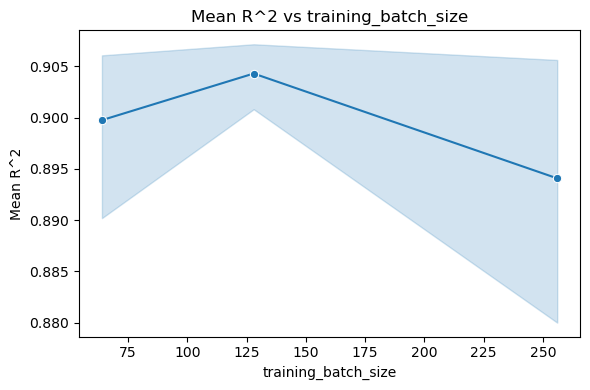

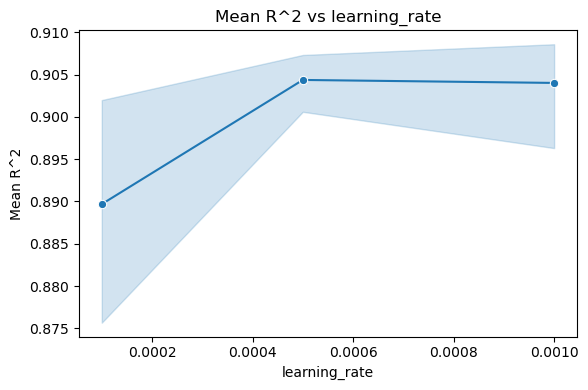

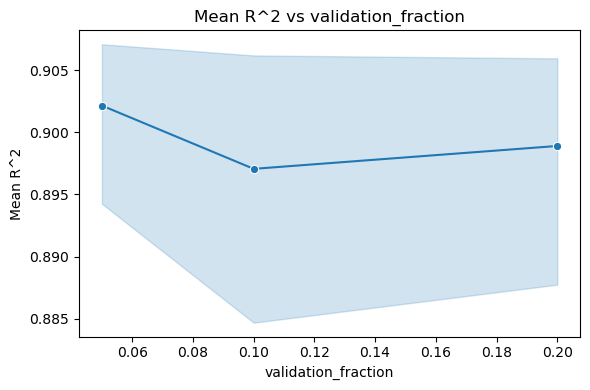

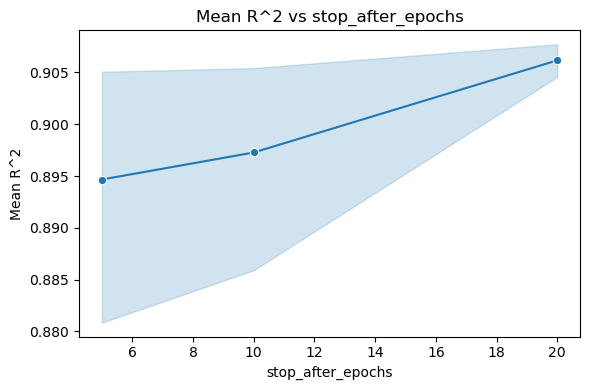

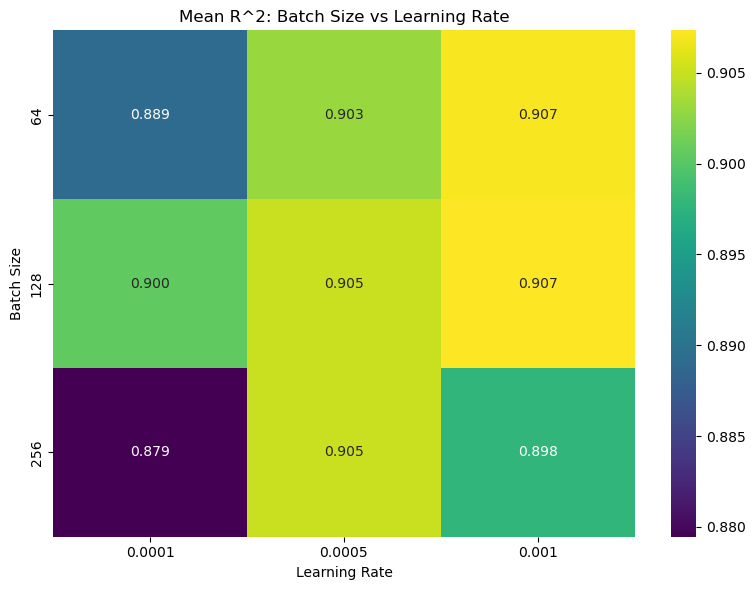

In [6]:
# Section 6: Visualize Hyperparameter Effects
import seaborn as sns

# Plot mean R^2 vs each hyperparameter
for param in grid_keys:
    plt.figure(figsize=(6, 4))
    sns.lineplot(x=param, y='mean_r2', data=results_df, marker='o')
    plt.title(f'Mean R^2 vs {param}')
    plt.ylabel('Mean R^2')
    plt.xlabel(param)
    plt.tight_layout()
    plt.show()

# Heatmap for two hyperparameters (example: batch size vs learning rate)
pivot = results_df.pivot_table(index='training_batch_size', columns='learning_rate', values='mean_r2')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='viridis')
plt.title('Mean R^2: Batch Size vs Learning Rate')
plt.ylabel('Batch Size')
plt.xlabel('Learning Rate')
plt.tight_layout()
plt.show()

In [8]:
best_params

training_batch_size    256.000000
learning_rate            0.000500
validation_fraction      0.100000
stop_after_epochs       10.000000
mean_r2                  0.915111
mean_rmse                0.016553
mean_width               0.119814
Name: 67, dtype: float64

In [ ]:
# Section 7: Save Hyperparameter Search Results
results_df.to_csv('sbi_hyperparam_search_results.csv', index=False)
print('Results saved to sbi_hyperparam_search_results.csv')

with open('sbi_hyperparam_search_best.json', 'w') as f:
    import json
    json.dump(best_params.to_dict(), f, indent=2)
print('Best hyperparameters saved to sbi_hyperparam_search_best.json')

Results saved to sbi_hyperparam_search_results.csv
Best hyperparameters saved to sbi_hyperparam_search_best.json
